In [47]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [59]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [48]:
import numpy as np
from tqdm import tqdm
from pathlib import Path
import openslide
import pandas as pd
import pickle

In [49]:
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.helper.wsi_loader import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric, PascalVOCMetricByDistance

In [50]:
slides_val = list(set([#'BAL Promyk Spray 4.svs',
                        'BAL AIA Blickfang Luft.svs'
                      ]))

slides_train = list(set(['BAL 1 Spray 2.svs', 
                         'BAL Booker Spray 3.svs',
                         'BAL Bubi Spray 1.svs', 
                         'BAL cent blue Luft 2.svs']))

In [51]:
asthma = Path('../../TrainPatches')

In [52]:
df = pd.read_pickle("../../TrainPatches/train_patches.pickle")
df.head()

,file_name,patch_name,vector,label
0,BAL 1 Spray 2.svs,BAL 1 Spray 2_12409_2930.png,"{'x1': 253, 'x2': 311, 'y1': 940, 'y2': 998}",Lymohozyten
1,BAL 1 Spray 2.svs,BAL 1 Spray 2_12409_3335.png,"{'x1': -39, 'x2': 43, 'y1': 970, 'y2': 1052}",Makrophagen
2,BAL 1 Spray 2.svs,BAL 1 Spray 2_12409_3335.png,"{'x1': 253, 'x2': 311, 'y1': 535, 'y2': 593}",Lymohozyten
3,BAL 1 Spray 2.svs,BAL 1 Spray 2_12409_3335.png,"{'x1': 403, 'x2': 473, 'y1': 973, 'y2': 1043}",Neutrophile
4,BAL 1 Spray 2.svs,BAL 1 Spray 2_12409_3335.png,"{'x1': 392, 'x2': 470, 'y1': 899, 'y2': 977}",Neutrophile


In [53]:
def get_y_func(path):
    
    annotations = df[df["patch_name"] == path.name]
    
    boxes = [[vector["y1"], vector["x1"], vector["y2"], vector["x2"]] for vector in annotations["vector"]]
    labels = [label for label in annotations["label"]]
             
    return [boxes, labels]

In [54]:
def split_func(path):
    
    file_name = df[df["patch_name"] == path.name]["file_name"].unique()[0]
    
    return file_name not in slides_val

In [55]:
size = 1024
bs = 16

In [60]:
data = (ObjectItemList.from_folder(asthma)
        #Where are the images? -> in coco
        .split_by_valid_func(split_func)
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True, size=size)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=bs, collate_fn=bb_pad_collate)).normalize()

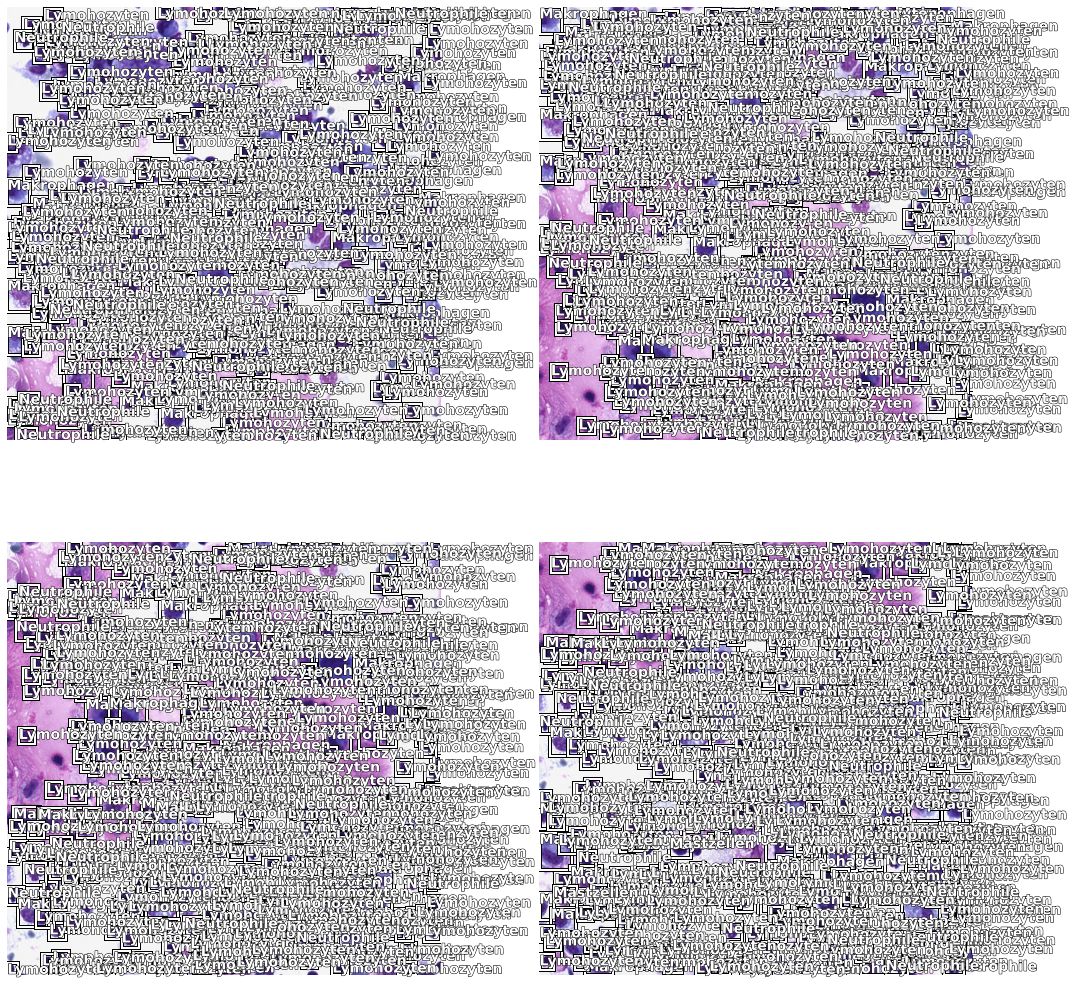

In [61]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(15,15))

In [62]:
scales = [.8, .9, 1, 1.1]
anchors = create_anchors(sizes=[(64, 64), (32,32)], ratios=[1], scales=scales)

In [63]:
crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=len(scales), sizes=[64, 32], chs=128, final_bias=-4., n_conv=2)

In [64]:
voc = PascalVOCMetricByDistance(anchors, size, [str(i) for i in data.train_ds.y.classes[1:]], radius=40)
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics], #BBMetrics, ShowGraph
                metrics=[voc])

In [65]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [66]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-Eosinophile,AP-Lymohozyten,AP-Makrophagen,AP-Mastzellen,AP-Neutrophile,time
0,1.894421,2.717476,0.167280,0.361384,2.356092,0.000000,0.338972,0.353986,0.001840,0.141604,36:02
1,1.067703,0.907116,0.235622,0.252250,0.654866,0.003563,0.334623,0.531930,0.112341,0.195652,20:31


KeyboardInterrupt: 

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

In [ ]:
learn.fit_one_cycle(10, 1e-3)

In [ ]:
learn.fit_one_cycle(10, 1e-3)

In [ ]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2)

In [ ]:
learn.fit_one_cycle(10, 1e-4)

In [ ]:
learn.fit_one_cycle(10, 1e-4)

In [ ]:
learn.fit_one_cycle(10, 1e-5)